In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_auc_score

# Load the data
data = pd.read_csv('diabetes.csv')
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
feature_names = data.columns[:-1]

# Data Preprocessing


In [54]:
# Handle missing values using KNN Imputer
imputer = KNNImputer(n_neighbors=5)
X_imputed = imputer.fit_transform(X)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Visualization


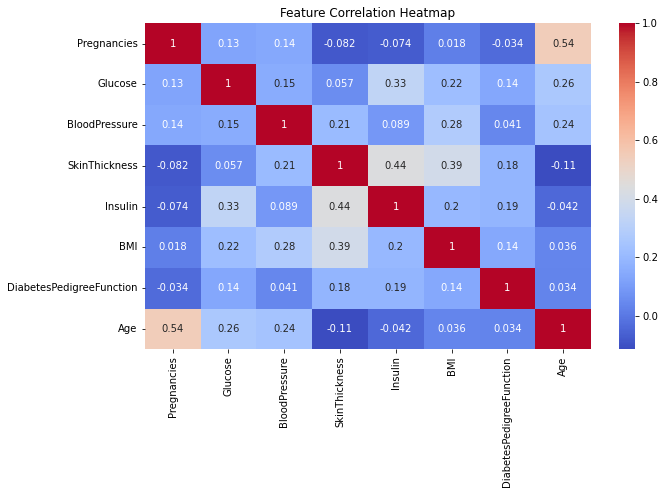

In [55]:
plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(X_scaled, columns=feature_names).corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Single Layer Perceptron

In [56]:
class SingleLayerPerceptron:
    def __init__(self, input_size, learning_rate=0.01, epochs=1000, batch_size=32):
        self.weights = np.random.randn(input_size) * 0.01
        self.bias = 0
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        n_samples = X.shape[0]
        for _ in range(self.epochs):
            for i in range(0, n_samples, self.batch_size):
                batch_X = X[i:i+self.batch_size]
                batch_y = y[i:i+self.batch_size]
                
                linear_output = np.dot(batch_X, self.weights) + self.bias
                y_pred = self.sigmoid(linear_output)
                
                error = batch_y - y_pred
                self.weights += self.learning_rate * np.dot(batch_X.T, error)
                self.bias += self.learning_rate * np.sum(error)
        return self

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return (self.sigmoid(linear_output) >= 0.5).astype(int)
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the perceptron
perceptron = SingleLayerPerceptron(input_size=X_train_scaled.shape[1])
perceptron.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = perceptron.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Accuracy: 75.97%
Confusion Matrix:
[[80 19]
 [18 37]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81        99
           1       0.66      0.67      0.67        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154



# hyperparameter tuning

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

class SingleLayerPerceptronCV(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size, learning_rate=0.01, epochs=1000):
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        self.weights = np.zeros(self.input_size)
        self.bias = 0
        for _ in range(self.epochs):
            for xi, yi in zip(X, y):
                y_pred = self.sigmoid(np.dot(xi, self.weights) + self.bias)
                error = yi - y_pred
                self.weights += self.learning_rate * error * xi
                self.bias += self.learning_rate * error
        return self

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return (self.sigmoid(linear_output) >= 0.5).astype(int)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

# Define parameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [500, 1000, 1500]
}

# Create GridSearchCV object
grid_search = GridSearchCV(SingleLayerPerceptronCV(input_size=X_train_scaled.shape[1]), 
                           param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train_scaled, y_train)

# Get best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)

# Use best model for predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with best model: {accuracy * 100:.2f}%")

Best parameters: {'epochs': 500, 'learning_rate': 0.01}
Best cross-validation score: 0.7687591630014661
Accuracy with best model: 75.97%


# Feature Analysis

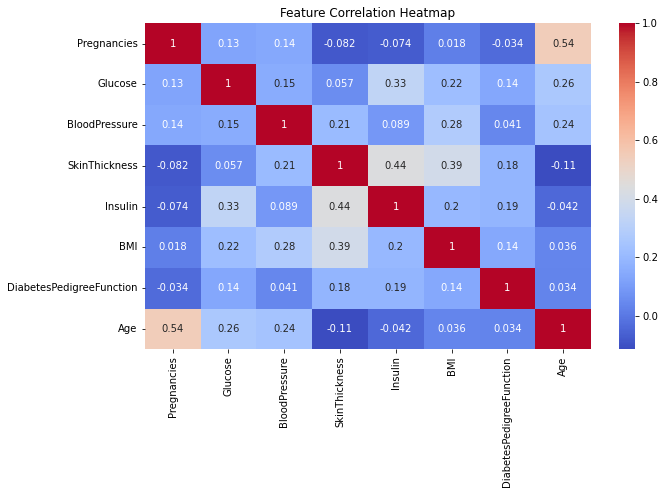

Feature Importance:
Glucose                     0.120056
BMI                         0.074577
Age                         0.048211
Pregnancies                 0.033392
Insulin                     0.023043
BloodPressure               0.017185
SkinThickness               0.016552
DiabetesPedigreeFunction    0.014177
dtype: float64


In [58]:
# Feature importance
mi_scores = mutual_info_classif(X_scaled, y)
mi_scores = pd.Series(mi_scores, index=feature_names)
mi_scores = mi_scores.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(X_scaled, columns=feature_names).corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

print("Feature Importance:")
print(mi_scores)

# SVM MODEL AND LOGISTIC REGRESSION MODEL


SVM Results:
Accuracy: 73.38%
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        99
           1       0.65      0.56      0.60        55

    accuracy                           0.73       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154


Logistic Regression Results:
Accuracy: 75.32%
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81        99
           1       0.65      0.67      0.66        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154


Feature Importance (Logistic Regression):
                    feature  importance
1                   Glucose    1.071132
5                       BMI    0.778152
7                       Age    0.421002
2             BloodP

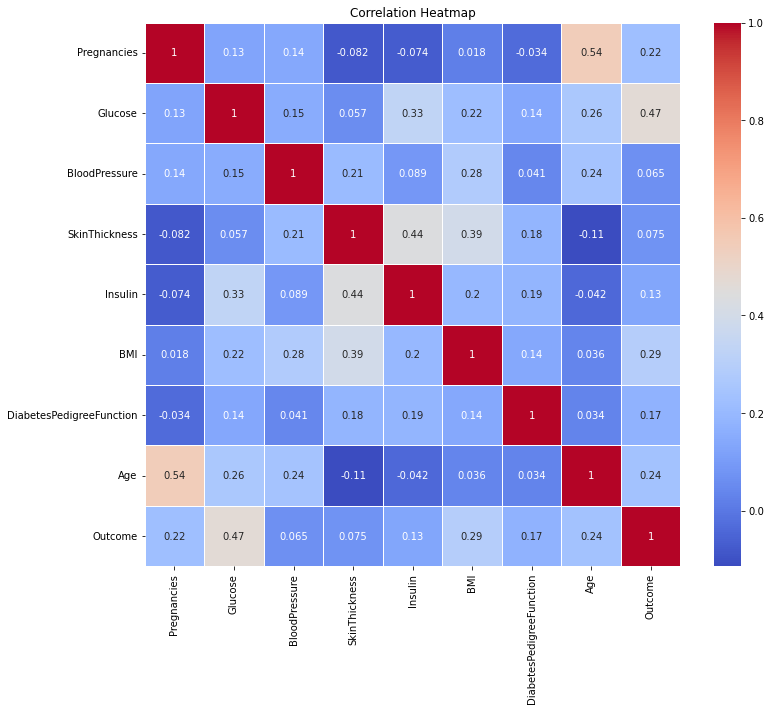

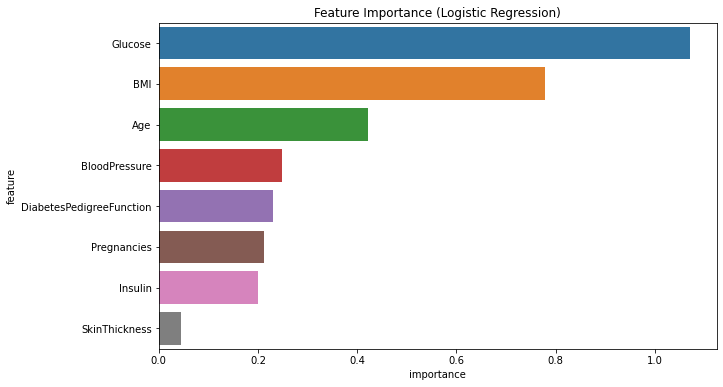

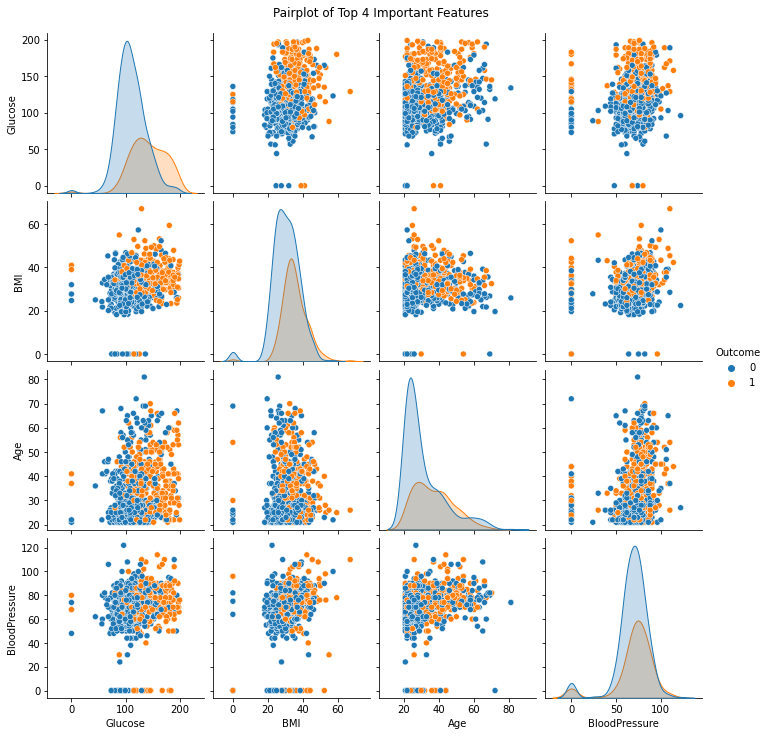

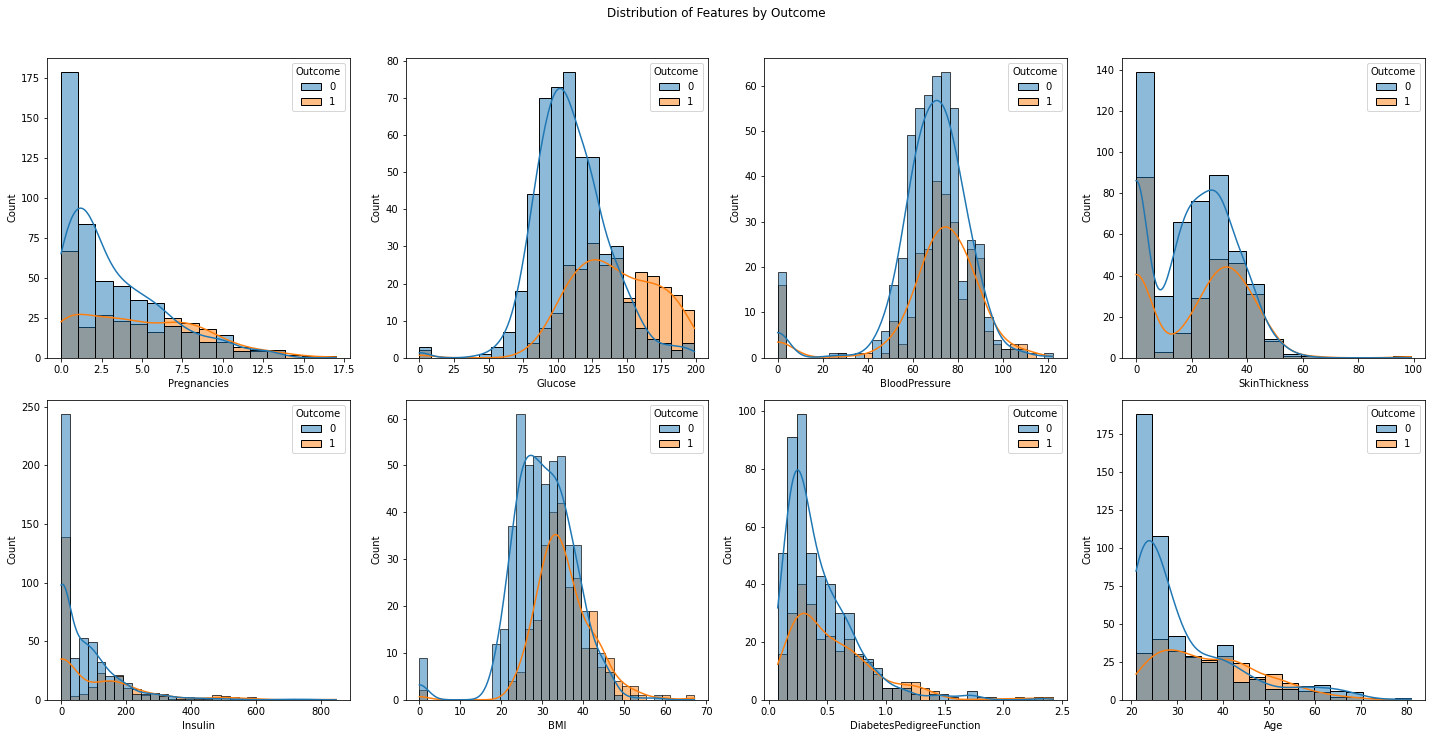

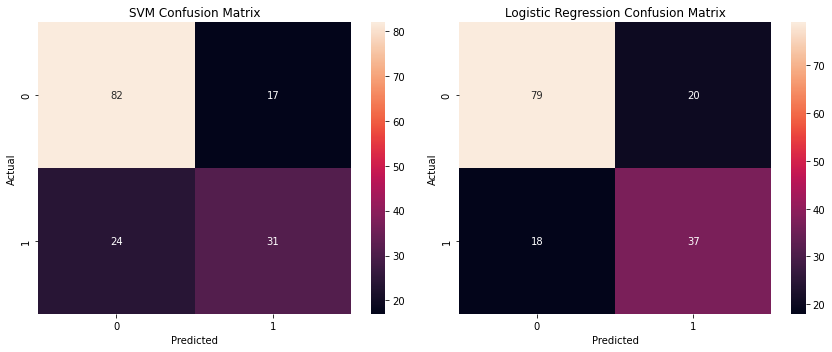

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the data
data = pd.read_csv('diabetes.csv')
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# SVM model
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)

print("SVM Results:")
print(f"Accuracy: {accuracy_score(y_test, svm_pred) * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, svm_pred))

# Logistic Regression model
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_scaled, y_train)
log_reg_pred = log_reg_model.predict(X_test_scaled)

print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, log_reg_pred) * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, log_reg_pred))

# Feature importance for Logistic Regression
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': abs(log_reg_model.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nFeature Importance (Logistic Regression):")
print(feature_importance)

# Visualizations

# 1. Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# 2. Feature Importance Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Logistic Regression)')
plt.show()

# 3. Pairplot for top 4 important features
top_features = feature_importance['feature'].head(4).tolist() + ['Outcome']
sns.pairplot(data[top_features], hue='Outcome', height=2.5)
plt.suptitle('Pairplot of Top 4 Important Features', y=1.02)
plt.show()

# 4. Distribution of features by outcome
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Distribution of Features by Outcome', y=1.02)
for i, feature in enumerate(X.columns):
    sns.histplot(data=data, x=feature, hue='Outcome', kde=True, ax=axes[i//4, i%4])
plt.tight_layout()
plt.show()

# 5. Confusion Matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt='d', ax=ax1)
ax1.set_title('SVM Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test, log_reg_pred), annot=True, fmt='d', ax=ax2)
ax2.set_title('Logistic Regression Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Random Forest

Random Forest Accuracy: 72.08%

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78        99
           1       0.61      0.62      0.61        55

    accuracy                           0.72       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.72      0.72      0.72       154


Feature Importance:
                    feature  importance
1                   Glucose    0.258864
5                       BMI    0.169984
7                       Age    0.140931
6  DiabetesPedigreeFunction    0.123768
2             BloodPressure    0.088134
0               Pregnancies    0.076551
4                   Insulin    0.076122
3             SkinThickness    0.065646


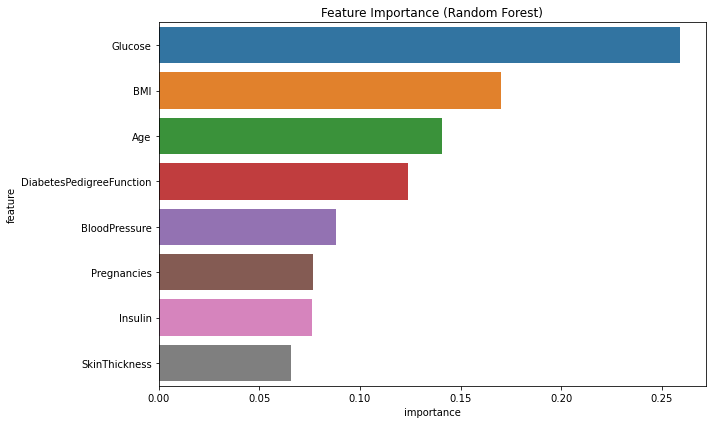

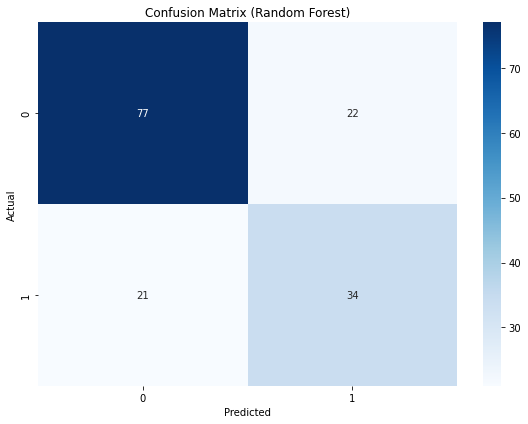

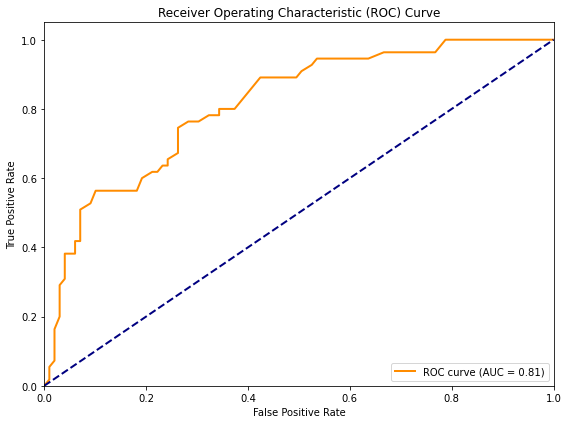

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

# Load the data
data = pd.read_csv('diabetes.csv')
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Visualizations

# 1. Feature Importance Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

# 2. Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 3. ROC Curve
from sklearn.metrics import roc_curve, auc
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# COMPARING ALL MODELS

Single Layer Perceptron Accuracy: 75.97%
SVM Accuracy: 73.38%
Logistic Regression Accuracy: 75.32%
Random Forest Accuracy: 72.08%


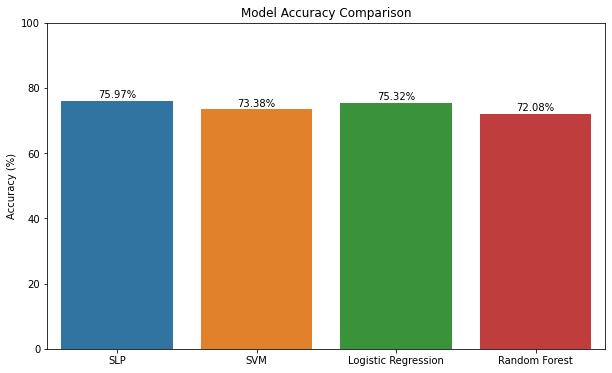

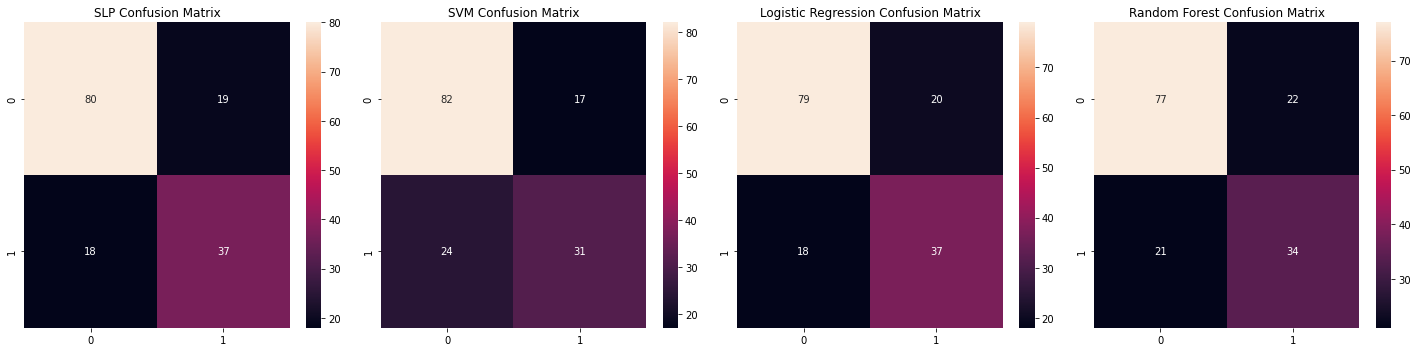

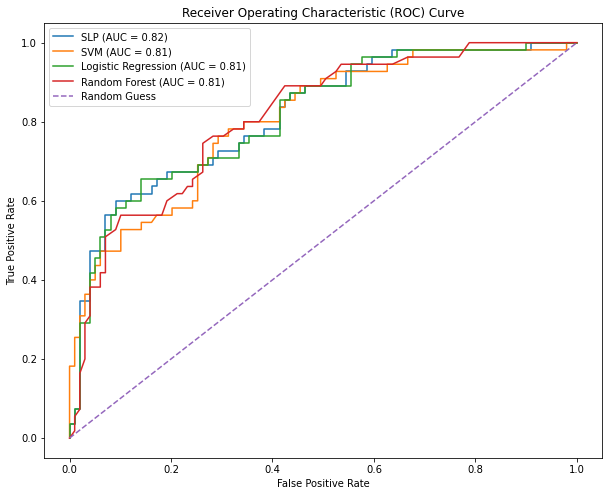

In [61]:
class SingleLayerPerceptron:
    def __init__(self, input_size, learning_rate=0.01, epochs=1000, batch_size=32):
        self.weights = np.random.randn(input_size) * 0.01
        self.bias = 0
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        n_samples = X.shape[0]
        for _ in range(self.epochs):
            for i in range(0, n_samples, self.batch_size):
                batch_X = X[i:i+self.batch_size]
                batch_y = y[i:i+self.batch_size]
                
                linear_output = np.dot(batch_X, self.weights) + self.bias
                y_pred = self.sigmoid(linear_output)
                
                error = batch_y - y_pred
                self.weights += self.learning_rate * np.dot(batch_X.T, error)
                self.bias += self.learning_rate * np.sum(error)
        return self

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return (self.sigmoid(linear_output) >= 0.5).astype(int)

    def predict_proba(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_output)
# Initialize models
slp_model = SingleLayerPerceptron(input_size=X_train_scaled.shape[1], learning_rate=0.01, epochs=1000)
svm_model = SVC(kernel='rbf', random_state=42, probability=True)
log_reg_model = LogisticRegression(random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train models
slp_model.fit(X_train_scaled, y_train)
svm_model.fit(X_train_scaled, y_train)
log_reg_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
slp_pred = slp_model.predict(X_test_scaled)
svm_pred = svm_model.predict(X_test_scaled)
log_reg_pred = log_reg_model.predict(X_test_scaled)
rf_pred = rf_model.predict(X_test_scaled)

# Calculate accuracies
slp_accuracy = accuracy_score(y_test, slp_pred) * 100
svm_accuracy = accuracy_score(y_test, svm_pred) * 100
log_reg_accuracy = accuracy_score(y_test, log_reg_pred) * 100
rf_accuracy = accuracy_score(y_test, rf_pred) * 100

print(f"Single Layer Perceptron Accuracy: {slp_accuracy:.2f}%")
print(f"SVM Accuracy: {svm_accuracy:.2f}%")
print(f"Logistic Regression Accuracy: {log_reg_accuracy:.2f}%")
print(f"Random Forest Accuracy: {rf_accuracy:.2f}%")
# 1. Accuracy Comparison
models = ['SLP', 'SVM', 'Logistic Regression', 'Random Forest']
accuracies = [slp_accuracy, svm_accuracy, log_reg_accuracy, rf_accuracy]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center')
plt.show()

# 2. Confusion Matrices
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

sns.heatmap(confusion_matrix(y_test, slp_pred), annot=True, fmt='d', ax=ax1)
ax1.set_title('SLP Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt='d', ax=ax2)
ax2.set_title('SVM Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, log_reg_pred), annot=True, fmt='d', ax=ax3)
ax3.set_title('Logistic Regression Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', ax=ax4)
ax4.set_title('Random Forest Confusion Matrix')

plt.tight_layout()
plt.show()

# 3. ROC Curves
slp_proba = slp_model.predict_proba(X_test_scaled)
svm_proba = svm_model.predict_proba(X_test_scaled)[:, 1]
log_reg_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

fpr_slp, tpr_slp, _ = roc_curve(y_test, slp_proba)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_proba)
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, log_reg_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr_slp, tpr_slp, label=f'SLP (AUC = {auc(fpr_slp, tpr_slp):.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc(fpr_svm, tpr_svm):.2f})')
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {auc(fpr_log_reg, tpr_log_reg):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc(fpr_rf, tpr_rf):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()